<a href="https://colab.research.google.com/github/100jy/dacon_ts_forecasting/blob/main/Seq2SeqModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install torchcontrib

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
import torch.optim.adam
from torchcontrib.optim import SWA
import datetime
import matplotlib.pyplot as plt 
from tqdm import tqdm

# feature engineering

In [ ]:
train = pd.read_csv("./drive/MyDrive/데이콘/train.csv", encoding = 'euc-kr')

# 시간 관련 변수들
train['DateTime'] = pd.to_datetime(train.DateTime)
train['Date'] = train.DateTime.dt.date
train['DayOfWeek'] = (train.DateTime.dt.weekday)/6

train['DayOfMon'] = ((train.DateTime).dt.day)/31
train['WeekOfYear'] = ((train.DateTime).dt.weekofyear)/40
train['Days'] = (train.DateTime.max() - train.DateTime).dt.days + 1
right = train.iloc[:,5:].groupby(train['Date']).mean().reset_index()
left = train.iloc[:,:5].groupby(train['Date']).sum().reset_index()
train  = pd.merge(left, right, on='Date')

def log_trans(x):
  return np.log(1+x)

train['Days'] = log_trans(train['Days'])


# ts feature 생성 
for target in ['사용자', '세션', '신규방문자', '페이지뷰']:
    train[f'{target}CumSum'] = train[target].cumsum()
    
    for k in [3,7,14,21]:
        train[f'{target}RollingMean{k}'] =  log_trans(train[target].rolling(k).mean())

    train[f'{target}RollingStd21'] =  log_trans(train[target].rolling(21).std().round(0))
    train[f'{target}DaysSince10000'] = (train[f'{target}CumSum'] > 10000) * 1
    train[f'{target}DaysSince100000'] = (train[f'{target}CumSum'] > 100000) * 1

    train[f'{target}RollingMeanDiff2w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean14'] + 1) - 1
    train[f'{target}RollingMeanDiff3w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean21'] + 1) - 1


    train[f'{target}CumSum'] = log_trans(train[target].cumsum())
    train[target] = log_trans(train[target])
    
train = train.dropna()

# Build Dataloader

 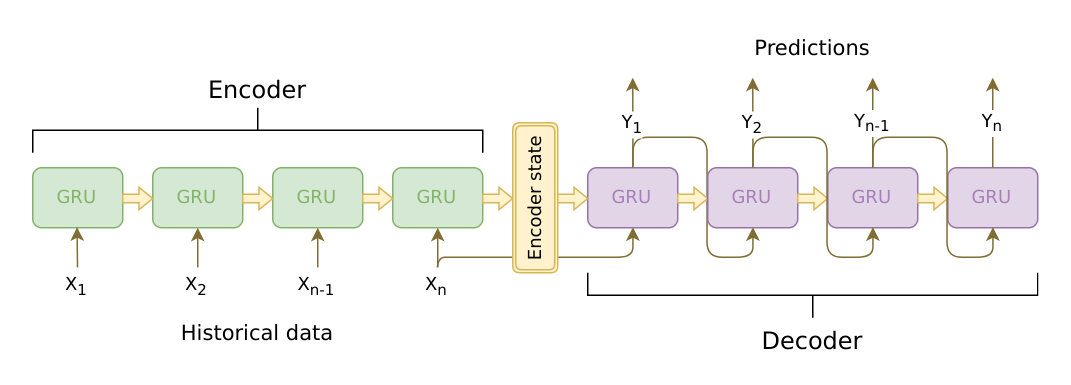